--------------------------

WORK IN PROGRESS
------------------------
--------------------------
--------------------------
--------------------------




# Introduction - Herd Inmunity Spain 

## Objectives
The goal of this project is to answer the following question: 
 - How many people are really dying because of the virus in Spain?
 - What percentage of the population is really infected?
 - Will Spain reach herd immunity? 


## Steps
In order to answer the questions defined above, we need to accomplish the following steps: 
1. Calculate the increment in the expected number of deaths per day 
2. Calculate number of real infected people from 2 weeks ago backwards
3. Calculate a model that fit the evolution of infected people. The model will give us:
     - Predictions for future real infected and real deaths 
     - Ro
4. Having Ro and the Infections we have all the values in the equation to determine whether we´ll reach herd immunity  

## Disclaimer

By no means, you should take the conclusions from this project as statements. I am not a doctor, neither an expert in epidemics. 





# Decrement in deaths due to confinement

We are going to calculate deaths provoke by causes that should not occur during the confinement. Then we are going to subtract this number for the expected daily death. 

This is a very basic approach, but since we have no data about the death distribution accross the year we are going to assume these deaths happen following a uniform distribution. 

I got the information about causes of death per year in Spain from the following page: https://www.ine.es/jaxiT3/Tabla.htm?t=7947

In [2]:
import pandas as pd
import requests
import io
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline 

In [3]:
deaths_causes = pd.read_csv("7947.csv", sep=";", thousands=".")

# These are the causes I have identified that should be reduced. 
non_existing_causes = ['090-102  XX.Causas externas de mortalidad']

# We are going to filter  only the information that we need
deaths_causes = deaths_causes[deaths_causes["Sexo"] == "Total"]
deaths_causes = deaths_causes[deaths_causes["Edad"] == "Todas las edades"]

# I am going to consider information about the last 5 years available 
deaths_causes = deaths_causes[deaths_causes["Periodo"] > 2013] 
deaths_causes = deaths_causes.loc[deaths_causes["Causa de muerte"].isin(non_existing_causes)]
deaths_causes = deaths_causes.groupby(by=["Causa de muerte"]).max() 
deaths_causes.drop(columns="Periodo")

# We are going to calculate the number of deaths that should be reduced due to quarantine per day
death_to_discount = round(deaths_causes["Total"].sum() / 365,0)
print("The number of deaths to subtract everyday due to the confinement is: ", death_to_discount)

The number of deaths to subtract everyday due to the confinement is:  43.0


# All-cause mortality


I got the information from this site: https://momo.isciii.es/public/momo/dashboard/momo_dashboard.html#nacional

In [71]:
url = "https://momo.isciii.es/public/momo/data"
csvdoc = requests.get(url).content
mortality = pd.read_csv(io.StringIO(csvdoc.decode('ISO-8859-1')), error_bad_lines=False)

mortality = mortality[mortality["nombre_sexo"] == "todos"]
mortality = mortality[mortality["nombre_gedad"] == "todos"]
mortality = mortality[mortality["ambito"] == "nacional"]
mortality["fecha_defuncion"] = mortality["fecha_defuncion"].astype("datetime64")

try: 
    mortality.drop(columns=["ambito", "cod_ambito", "cod_ine_ambito", "nombre_ambito", "cod_sexo",
                        "nombre_sexo", "cod_gedad", "nombre_gedad", "defunciones_observadas_lim_sup",
                       "defunciones_observadas_lim_inf"], inplace=True)
    mortality.rename(columns={"defunciones_esperadas": "expected_deaths", 
                          "defunciones_observadas":"observed_deaths",
                         "fecha_defuncion":"date"}, inplace=True)
except: 
    pass

#Here we remove the last week, since according to the site, 
#info from the last few days is not enterely reliable. 
mortality = mortality.iloc[:-7,:] 

confinement_date = '2020-03-14'
eighteen_days_after_confinement = '2020-04-01'
march_8 = '2020-03-08'


Text(2020-04-01, 700, '18 Days Since Confinement')

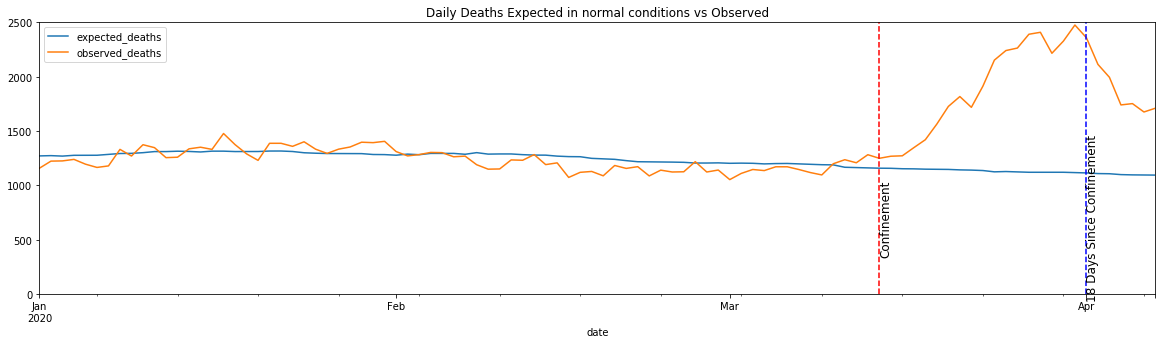

In [72]:
ax = mortality.plot(x="date", y= ["expected_deaths", "observed_deaths"], 
                    figsize=(20,5), ylim=(0,2500), xlim=('2020-01-01', max(mortality["date"])),
                    title="Daily Deaths Expected in normal conditions vs Observed")
ax.axvline(confinement_date, color='red', linestyle='--') # red line for the beginning of the confinement
ax.axvline(eighteen_days_after_confinement, color='b', linestyle='--') # blue line for the beginning of the effects from the confinement
ax.text(x=confinement_date,  y=700,s="Confinement", fontsize=12, rotation=90, verticalalignment='center')
ax.text(x=eighteen_days_after_confinement,  y=700,s="18 Days Since Confinement", fontsize=12, 
        rotation=90, verticalalignment='center')

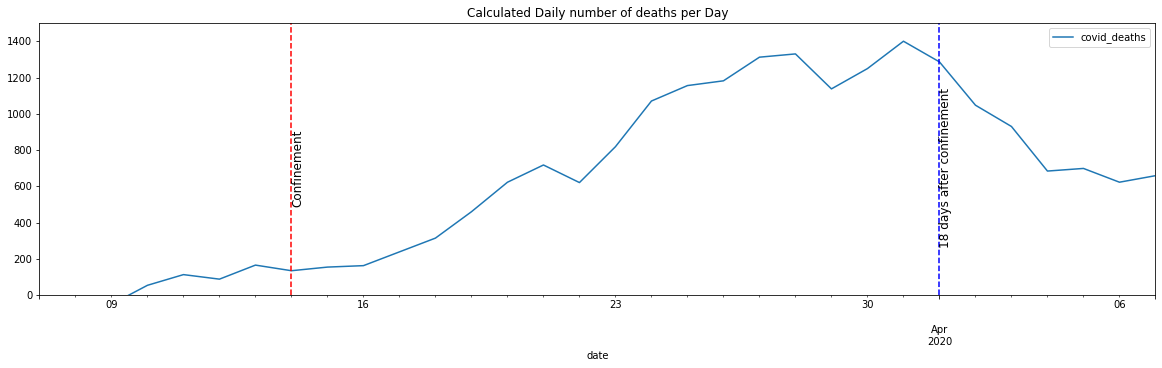

In [95]:
#The two lines from the previous graph correlate very well until half march, when they begin to diverge. 
#My hypothesis is that the difference between the number of deaths of both lines is a good aproximation to the real number of deaths caused by covid19


mortality["covid_deaths"] = (mortality["observed_deaths"] 
                                    - mortality["expected_deaths"] 
                                     + death_to_discount) # We discount the deaths caused by accidents that should reduce dramatically during the confinement


ax = mortality.plot(x="date", y= ["covid_deaths"], figsize=(20,5), ylim=(0,1500),
                    xlim=('2020-03-07', max(mortality["date"])), title="Calculated Daily number of deaths per Day")
ax.axvline(confinement_date, color='red', linestyle='--') # red line for the beginning of the confinement
ax.axvline(eighteen_days_after_confinement, color='b', linestyle='--') # blue line for the beginning of the effects from the confinement
ax.text(x=confinement_date,  y=700,s="Confinement", fontsize=12, rotation=90, verticalalignment='center')
ax.text(x=eighteen_days_after_confinement,  y=700,s="18 days after confinement", fontsize=12, 
        rotation=90, verticalalignment='center');


# Real Infected


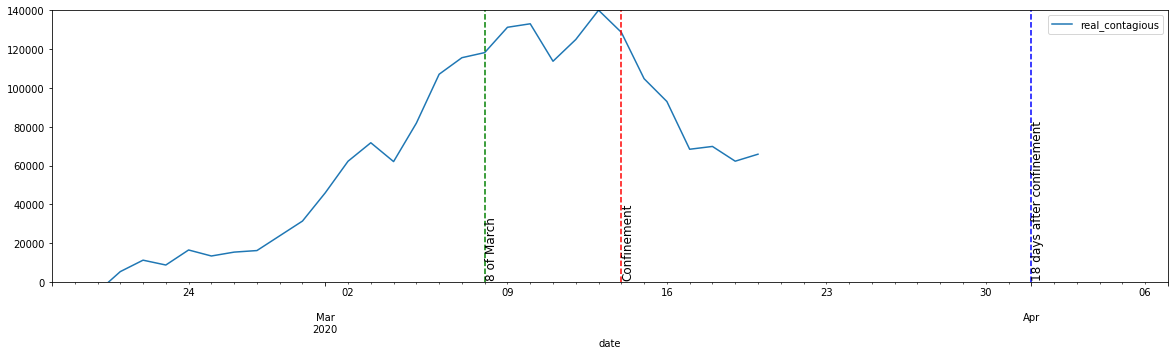

In [26]:
#There is big debate about the real mortality rate, for this experiment we are going to consider 1% 
mortality_rate= 0.01

mortality["real_contagious"] = mortality["covid_deaths"] / mortality_rate
mortality["real_contagious"] = mortality["real_contagious"].shift(periods=-18, fill_value=None)

ax = mortality.plot(x="date", y= ["real_contagious"], figsize=(20,5),
                    ylim=(0,max(mortality["real_contagious"])),
                          xlim=('2020-02-18', max(mortality["date"])))
ax.axvline(confinement_date, color='red', linestyle='--') # red line for the beginning of the confinement
ax.axvline(eighteen_days_after_confinement, color='b', linestyle='--') # blue line for the beginning of the effects from the confinement
ax.axvline(march_8, color='g', linestyle='--') # blue line for the beginning of the effects from the confinement

ax.text(x=confinement_date,  y=2500,s="Confinement", fontsize=12, rotation=90)
ax.text(x=eighteen_days_after_confinement,  y=2500,s="18 days after confinement", fontsize=12, rotation=90)
ax.text(x=march_8,  y=2500,s="8 of March", fontsize=12, rotation=90);

mortality["covid_deaths"] = mortality["covid_deaths"]
mortality["real_contagious"] = mortality["real_contagious"]


In [39]:
## Total Number of Real Infected People
mortality_2 = mortality[mortality["date"] > '2020-02-20']
print("The number of calculated infected people in Spain as of ",
      mortality_2["date"].iloc[-18].strftime("%d %b %Y"),
      "is",
      '{:,}'.format(int(round(mortality_2["real_contagious"].sum(),0))).replace(',', ' '))

The number of calculated infected people in Spain as of  21 Mar 2020 is 2 042 500


# Official Data 


In [73]:
#Now we are going to compare the official information with the data we have calculated

#Downloading data from an official source
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
csvdoc = requests.get(url).content
official_data = pd.read_csv(io.StringIO(csvdoc.decode('ISO-8859-1')), error_bad_lines=False)

official_data = official_data[official_data["countriesAndTerritories"] == "Spain"]
official_data["date"] = pd.to_datetime(official_data['dateRep'], dayfirst=True)
official_data.drop(columns=["countryterritoryCode", "popData2018","dateRep", "day", "month", "year", 
                            "geoId", "countriesAndTerritories"], inplace=True)

official_data.rename(columns={"deaths": "official_deaths", "cases": "official_infected"}, inplace=True)

official_data.sort_values(by="date", inplace=True)
official_data = official_data[official_data["date"] > "2020-02-29"]


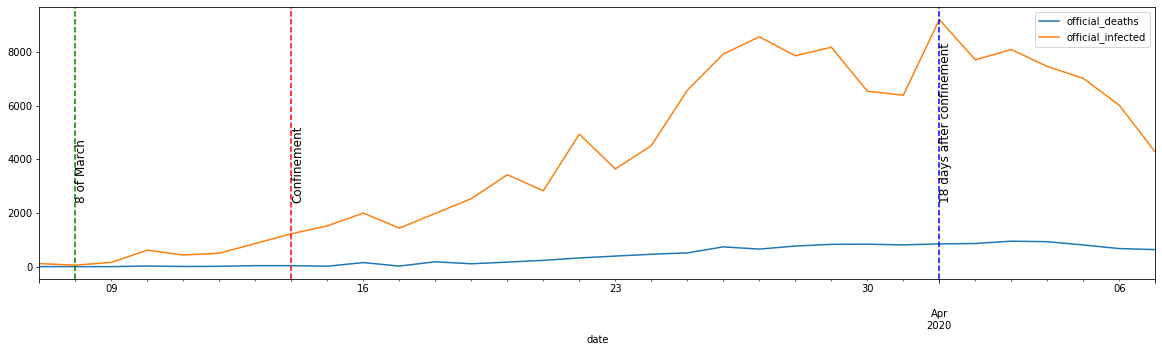

In [78]:
#Here we plot the official data about deaths 
ax = official_data.plot(x="date", 
                        y= ["official_deaths", "official_infected"],
                        figsize=(20,5), 
                        xlim = ('2020-03-07', max(mortality["date"]))
                       )
ax.axvline(confinement_date, color='red', linestyle='--') # red line for the beginning of the confinement
ax.axvline(eighteen_days_after_confinement, color='b', linestyle='--') # blue line for the beginning of the effects from the confinement
ax.axvline(march_8, color='g', linestyle='--') # blue line for the beginning of the effects from the confinement
ax.text(x=confinement_date,  y=2500,s="Confinement", fontsize=12, rotation=90)
ax.text(x=eighteen_days_after_confinement,  y=2500,s="18 days after confinement", fontsize=12, rotation=90)
ax.text(x=march_8,  y=2500,s="8 of March", fontsize=12, rotation=90);


In [79]:
fig = px.line(official_data, x='date', y='official_deaths', title='')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="last 7 days", step="day", stepmode="backward"),
            dict(count=1, label="last 30 days", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
xaxis=('2020-03-07', max(mortality["date"]))

In [98]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=official_data["date"], y=official_data["official_deaths"],
                    mode='lines',
                    name='calculated deaths'))
fig.add_trace(go.Scatter(x=mortality["date"], y=mortality["covid_deaths"],
                    mode='lines',
                    name='calculated deaths'))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="last 7 days", step="day", stepmode="backward"),
            dict(count=1, label="last 30 days", step="month", stepmode="backward"),
            dict(count=3, label="las 3 months", step="month", stepmode="backward"),        ])
    )
)

fig.show()

In [82]:
official_data.head(3)

,official_infected,official_deaths,date
9416,32,0,2020-03-01
9415,17,0,2020-03-02
9414,31,0,2020-03-03


In [96]:
mortality.head(3)

,date,observed_deaths,expected_deaths,defunciones_esperadas_q01,defunciones_esperadas_q99,covid_deaths
0,2018-03-28,1179,1121.50,992.43,1233.72,100.50
1,2018-03-29,1168,1125.00,992.43,1233.72,86.00
2,2018-03-30,1156,1123.25,990.36,1233.72,75.75


# Next Steps:
    - To do the same but to a regional level. data from Movo and Inem is avaibla for province
    - Add official data to contrast 
    
# Limitations:
    - Debido a la sobrecarga del sistema sanitario, la tasa de mortalidad durante la primera quincena del mes de marzo ha podido ser superior al esperado 
    - Confinement is going to have an important impact on the trasmission of the virus. We should consider the transmission rate is going to change before, after and even depending the severity of the confinement
    